In [3]:
import numpy as np
import pandas as pd

import folktables
ACSIncomeNew = folktables.BasicProblem(
    features=[
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [2]:
# def subsample_urm(df, random_state):
#     df_urm = select_rows(df, 'urm')
#     df_wa = select_rows(df, 'wa')
#     p_wa = df_wa['grade9thbin'].mean()
#     df_urm_h = df_urm[df_urm['grade9thbin']>0]
#     df_urm_l = df_urm[df_urm['grade9thbin']==0]
#     subsample_size = int(len(df_urm_h) * (1-p_wa)/p_wa)
#     np.random.seed(random_state)
#     sample_idx = np.random.permutation(np.arange(len(df_urm_l)))[:subsample_size]
#     df_l_sub = df_urm_l.iloc[sample_idx]

#     df_urm_new = pd.concat([df_urm_h, df_l_sub])
#     return pd.concat([df_urm_new, df_wa])

In [3]:
# def subsample_wa(df, random_state):
#     df_urm = select_rows(df, 'urm')
#     df_wa = select_rows(df, 'wa')
#     p_u = df_urm['grade9thbin'].mean()
#     df_wa_h = df_wa[df_wa['grade9thbin']>0]
#     df_wa_l = df_wa[df_wa['grade9thbin']==0]
#     subsample_size = int(len(df_wa_l) * p_u/(1-p_u))
#     np.random.seed(random_state)
#     sample_idx = np.random.permutation(np.arange(len(df_wa_h)))[:subsample_size]
#     df_h_sub = df_wa_h.iloc[sample_idx]

#     df_wa_new = pd.concat([df_wa_l, df_h_sub])
#     return pd.concat([df_wa_new, df_urm])

In [4]:

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# from tqdm import tqdm

# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# # from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score,auc
# from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score,auc


# import folktables

# from folktables import ACSDataSource, ACSEmployment

# data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
# acs_data = data_source.get_data(states=["AL"], download=True)
# features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [5]:
from sklearn.linear_model import LogisticRegression

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_ca = data_source.get_data(states=["CA"], download=True)

ca_features, ca_label, ca_group = ACSIncomeNew.df_to_numpy(acs_ca)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.2, random_state=0)



model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

yhat = model.predict(X_test)

In [1]:
X_train

NameError: name 'X_train' is not defined

In [6]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit

In [7]:
import numpy as np
import pandas as pd
import json

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit



from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.impute import KNNImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.inspection import permutation_importance


def select_rows_p(df, eval_sel, p, drop_sens=False):

    # Sample p fraction of group1 (male, wa) students and (1-p) fraction of group0 (female, urm) students # 
    df_group1_sub = select_rows(df, eval_sel[1], drop_sens)
    df_group0_sub = select_rows(df, eval_sel[0], drop_sens)
    
    group1_sample_size, group0_sample_size = int(len(df_group1_sub)*p), int(len(df_group1_sub)*(1-p))
    
    group1_sample_idx = np.random.permutation(np.arange(len(df_group1_sub)))[:group1_sample_size]
    group0_sample_idx = np.random.permutation(np.arange(len(df_group0_sub)))[:group0_sample_size]
    
    df_group1_sub = df_group1_sub.iloc[group1_sample_idx]
    df_group0_sub = df_group0_sub.iloc[group0_sample_idx]
    
    return pd.concat([df_group1_sub, df_group0_sub])

    
    
def eval_binary_metrics(pred_model, X_eval, y_eval, groups, drop_sens=False): 
    # For binary labels #
    metrics = {}
    for g_sel in groups: 
        X_eval_g = select_rows(X_eval, g_sel, drop_sens=drop_sens)
        y_eval_g= y_eval.loc[X_eval_g.index]
        y_pred_g = pred_model.predict(X_eval_g)
    
        c= confusion_matrix(y_eval_g, y_pred_g)
        metrics[g_sel] = {}
        metrics[g_sel]['Size'] = c[0][0]+c[0][1]+c[1][0]+c[1][1]
        metrics[g_sel]['True Parity'] = (c[1][0]+c[1][1])/(c[0][0]+c[0][1]+c[1][0]+c[1][1])
        metrics[g_sel]['Parity'] = (c[0][1]+c[1][1])/(c[0][0]+c[0][1]+c[1][0]+c[1][1])
        metrics[g_sel]['TNR'] = c[0][0]/(c[0][0]+c[0][1])
        metrics[g_sel]['FPR'] = c[0][1]/(c[0][0]+c[0][1])
        metrics[g_sel]['TPR']  = c[1][1]/(c[1][0]+c[1][1])
        metrics[g_sel]['FNR'] = c[1][0]/(c[1][0]+c[1][1])
        metrics[g_sel]['PPV'] = c[1][1]/(c[0][1]+c[1][1])
        metrics[g_sel]['NPV'] = c[0][0]/(c[0][0]+c[1][0])
        metrics[g_sel]['Accuracy'] = accuracy_score(y_eval_g, y_pred_g)
    return metrics

def train_model(X_train, y_train, model='randomforest'):
    if model == 'randomforest':
        pred_model =  RandomForestClassifier(max_depth=16, min_samples_leaf=3, random_state=42)
    elif model == 'logistic':
        pred_model = LogisticRegression(multi_class='ovr', C = 1)
    elif model == 'svm': 
        pred_model = svm.SVC(kernel='rbf', probability=True) 

    pred_model.fit(X_train, y_train)

    return pred_model 


def display_metrics_table(metrics):
    g_labels = list(metrics[0].keys())
    metric_labels = ['Parity', 'FPR', 'FNR',  'PPV', 'NPV', 'Accuracy']
    metric_table = {}
    for g in g_labels:
        metric_table[g] = {}
        for m in metric_labels: 
            metric_arr = np.array([x[g][m] for x in metrics])
            metric_table[g][m] = '{:.3f} \u00B1 {:.3f}'.format(metric_arr.mean(), metric_arr.std())
    return metric_table



In [8]:
from tabulate import tabulate


In [9]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome, generate_categories
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline


from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split, KFold, ShuffleSplit

from scipy.stats import sem
from tqdm import tqdm




from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

# The ACS data source contains data for all fifty states, each of which has a
# slightly different distribution of features and response. This increases the
# diversity of environments in which we can evaluate our methods. For instance, we
# can generate another `ACSEmployment` task using data from Texas and repeat the
# experiment
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_ca = data_source.get_data(states=["CA"], download=True)

ca_features, ca_label, ca_group = ACSIncomeNew.df_to_numpy(acs_ca)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

yhat = model.predict(X_test)


printmd("## California Data")


print("Number of samples for the 'male' group:", np.sum((group_test == 1)))


print("Number of samples for the 'female' group:", np.sum((group_test == 2)))



## California Data

Number of samples for the 'male' group: 20621
Number of samples for the 'female' group: 18512


In [10]:
def process_missing_values(df, y_label, col_thresh =100, impute_method='drop'):
    
    # Drop columns with too many missing values (default threshold =100)
    df_new = df.dropna(subset=[y_label])
#     col_thresh = int(df.mcid.count()/5)
#     df_new = df_new.dropna(axis=1, thresh=col_thresh)
    
    if impute_method == 'drop':
        df_new = df_new.dropna()  # Dropping all the rows with "any" missing value
    elif impute_method == 'mean':
        df_new = df_new.fillna(df_new.mean())
    elif impute_method == 'median':
        df_new = df_new.fillna(df_new.median())
    elif impute_method == 'knn':      
        df_num = df_new.select_dtypes(np.number)
        df_text = df_new.select_dtypes(exclude=[np.number])
        imputer = KNNImputer(n_neighbors=5)
        df_num = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns, index=df_num.index)
        df_new = pd.concat([df_text, df_num], axis=1)
    elif impute_method == 'iterative':
        df_num = df_new.select_dtypes(np.number)
        df_text = df_new.select_dtypes(exclude=[np.number])
        imputer = IterativeImputer()
        df_num = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns, index=df_num.index)
        df_new = pd.concat([df_text, df_num], axis=1)

    return df_new


In [11]:
group_labels = ['f', 'm', 'w', 'b', ]


# What we want to predict #
pred_label = 'PINCP'
# exclude_labels= categorical_labels | grade_labels
row_sel = 'Female'
eval_sel = ['Female', 'Male']
# model = 'randomforest'
model = 'logistic'


# impute = 'knn'

In [12]:
acs_ca

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000004,9,1,3701,4,6,1013097,32,30,...,34,60,60,7,8,59,33,8,58,32
1,P,2018GQ0000013,9,1,7306,4,6,1013097,45,18,...,0,0,0,91,46,46,0,89,45,0
2,P,2018GQ0000016,9,1,3755,4,6,1013097,109,69,...,105,232,226,110,114,217,2,111,2,106
3,P,2018GQ0000020,9,1,7319,4,6,1013097,34,25,...,67,0,34,34,69,0,34,35,0,0
4,P,2018GQ0000027,9,1,6511,4,6,1013097,46,31,...,47,81,10,11,79,47,44,81,47,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378812,P,2018HU1400891,9,2,1308,4,6,1013097,94,61,...,26,77,21,171,86,31,25,82,82,106
378813,P,2018HU1400893,9,1,7108,4,6,1013097,172,40,...,173,53,288,47,199,181,164,178,176,154
378814,P,2018HU1400893,9,2,7108,4,6,1013097,156,43,...,142,51,259,46,171,150,152,169,165,148
378815,P,2018HU1400893,9,3,7108,4,6,1013097,172,23,...,178,56,297,56,189,167,167,177,180,155


In [14]:
acs_ca.shape

(378817, 286)

In [15]:
acs_ca.describe()

,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
count,378817.0,378817.000000,378817.000000,378817.0,378817.0,378817.0,378817.000000,378817.000000,378817.000000,56490.000000,...,378817.000000,378817.000000,378817.000000,378817.000000,378817.000000,378817.000000,378817.000000,378817.000000,378817.000000,378817.000000
mean,9.0,2.255208,5498.989858,4.0,6.0,1013097.0,104.422571,40.371145,1.921218,1998.292742,...,104.422571,104.422571,104.422571,104.422571,104.422571,104.422571,104.422571,104.422571,104.422571,104.422571
std,0.0,1.481371,2683.815709,0.0,0.0,0.0,75.636497,23.219541,1.527332,13.847503,...,98.093987,98.982807,97.080119,98.824923,97.660484,97.982638,97.754083,97.584822,96.598536,98.728730
min,9.0,1.000000,101.000000,4.0,6.0,1013097.0,1.000000,0.000000,1.000000,1939.000000,...,0.000000,0.000000,0.000000,0.000000,-18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.0,1.000000,3724.000000,4.0,6.0,1013097.0,59.000000,21.000000,1.000000,1990.000000,...,40.000000,39.000000,42.000000,40.000000,42.000000,41.000000,41.000000,42.000000,43.000000,40.000000
50%,9.0,2.000000,5909.000000,4.0,6.0,1013097.0,82.000000,40.000000,1.000000,2000.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
75%,9.0,3.000000,7315.000000,4.0,6.0,1013097.0,126.000000,59.000000,4.000000,2009.000000,...,133.000000,133.000000,133.000000,133.000000,132.000000,133.000000,133.000000,132.000000,132.000000,133.000000
max,9.0,20.000000,11300.000000,4.0,6.0,1013097.0,1901.000000,94.000000,5.000000,2018.000000,...,1934.000000,2077.000000,2068.000000,3156.000000,1949.000000,2237.000000,2395.000000,1777.000000,2165.000000,2238.000000


In [ ]:
df_new.shape

In [ ]:
acs_ca.shape

In [22]:
def predict_demographic_splits(self, df_new, parameters_dict, drop_sens=False):
    self.dataset = parameters_dict['dataset']
    self.pred_label = parameters_dict['pred_label']
    train_sel, test_sel = parameters_dict['train_sel'], parameters_dict['test_sel']
    self.group = test_sel
    num_demographic_splits = parameters_dict['num_demographic_splits']
    if num_demographic_splits > 1:
        self.sample_p = np.linspace(0, 1, num_demographic_splits + 1)
    else:
        self.sample_p = np.linspace(0.5, 0.5, 1)
    # Originally a list because JSON cannot store python sets, we want to turn into set
    exclude_labels = set(parameters_dict['exclude_labels'])
    self.modelType = parameters_dict['model']
    impute = parameters_dict['impute']
    cv = parameters_dict['cv']
    se_type = parameters_dict['se_type']
    displayBool = parameters_dict['plot']
    
    # Assigning S, classifying 'f' and 'm' values to 0 and 1
    if self.group == ['f', 'm']:
        sens_attributes = {'SEX'}
        S = (acs_ca[sens_attributes]==1).astype(int)
        sens_attribute_dict = {'2': 'f', '1': 'm'}
        
    if self.group == ['b', 'w']:
        sens_attributes = {'RAC1P'}
        S = acs_ca[sens_attributes]<0.2
        sens_attribute_dict = {'2': 'b', '1': 'wa'}
        
    X = df_new[x_labels]
    y = df_new[self.pred_label]
    
    metrics = []
    fnr_list = []
    fpr_list = []
    acc_list = []
    
    # P-samples of the demographic splits for training the model
    for idx, p in enumerate(self.sample_p):
        single_model = Model(self.dataset, self.modelType, self.predLabel)
        metric_cv = single_model.predict_cross_validate(X, S, y, train_sel, test_sel, p, sens_attributes, sens_attribute_dict, x_labels, cv=cv, drop_sens=drop_sens)
            
        # Displaying the pandas df for each demographic split's metrics
        # if displayBool:
        print('p=', p)
            
        metrics_obj = Metrics(self.dataset, self.modelType, self.predLabel, cv)
        metrics_obj.assign_metrics(metric_cv)       
            
        metric_cv = metrics_obj.display_metrics(metric_cv, displayBool, se_type)
            
        self.metrics_cv.append(metric_cv)
        self.fnr_list.append(metric_cv.loc['FNR'])
        self.fpr_list.append(metric_cv.loc['FPR'])
        self.acc_list.append(metric_cv.loc['Accuracy'])
            
            
    return self
        

In [21]:
acs_data.describe()

,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTR,LANX,MAR,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPI,MLPJ,MLPK,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RELP,RETP,SCH,SCHG,SCHL,SEMP,SEX,SSIP,SSP,WAGP,WKHP,WKL,WKW,WRK,YOEP,ANC,ANC1P,ANC2P,DECADE,DIS,DRIVESP,ESP,ESR,FOD1P,FOD2P,HICOV,HISP,INDP,JWAP,JWDP,LANP,MIGPUMA,MIGSP,MSP,NATIVITY,NOP,OC,OCCP,PAOC,PERNP,PINCP,POBP,POVPIP,POWPUMA,POWSP,PRIVCOV,PUBCOV,QTRBIR,RAC1P,RAC2P,RAC3P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACPI,RACSOR,RACWHT,RC,SCIENGP,SCIENGRLP,SFN,SFR,VPS,WAOB,FAGEP,FANCP,FCITP,FCITWP,FCOWP,FDDRSP,FDEARP,FDEYEP,FDISP,FDOUTP,FDPHYP,FDRATP,FDRATXP,FDREMP,FENGP,FESRP,FFERP,FFODP,FGCLP,FGCMP,FGCRP,FHICOVP,FHINS1P,FHINS2P,FHINS3C,FHINS3P,FHINS4C,FHINS4P,FHINS5C,FHINS5P,FHINS6P,FHINS7P,FHISP,FINDP,FINTP,FJWDP,FJWMNP,FJWRIP,FJWTRP,FLANP,FLANXP,FMARP,FMARHDP,FMARHMP,FMARHTP,FMARHWP,FMARHYP,FMIGP,FMIGSP,FMILPP,FMILSP,FOCCP,FOIP,FPAP,FPERNP,FPINCP,FPOBP,FPOWSP,FPRIVCOVP,FPUBCOVP,FRACP,FRELP,FRETP,FSCHGP,FSCHLP,FSCHP,FSEMP,FSEXP,FSSIP,FSSP,FWAGP,FWKHP,FWKLP,FWKWP,FWRKP,FYOEP,PWGTP1,PWGTP2,PWGTP3,PWGTP4,PWGTP5,PWGTP6,PWGTP7,PWGTP8,PWGTP9,PWGTP10,PWGTP11,PWGTP12,PWGTP13,PWGTP14,PWGTP15,PWGTP16,PWGTP17,PWGTP18,PWGTP19,PWGTP20,PWGTP21,PWGTP22,PWGTP23,PWGTP24,PWGTP25,PWGTP26,PWGTP27,PWGTP28,PWGTP29,PWGTP30,PWGTP31,PWGTP32,PWGTP33,PWGTP34,PWGTP35,PWGTP36,PWGTP37,PWGTP38,PWGTP39,PWGTP40,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
count,47777.0,47777.000000,47777.000000,47777.0,47777.0,47777.0,47777.000000,47777.000000,47777.000000,594.000000,26323.000000,45475.000000,47777.000000,47777.000000,40276.000000,45475.000000,1116.000000,4697.000000,45475.000000,1914.000000,10121.000000,31728.000000,593.000000,1152.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,40276.000000,19050.000000,18581.000000,19704.000000,45475.000000,47777.000000,29715.000000,29715.000000,29715.000000,29715.000000,29715.000000,47318.000000,39146.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000,39726.000000,39726.000000,39726.000000,39726.000000,39726.000000,40276.000000,40276.000000,47777.000000,40276.000000,46422.000000,10465.000000,46422.000000,40276.000000,47777.000000,40276.000000,40276.000000,40276.000000,22448.000000,39726.000000,22448.000000,35598.000000,1799.000000,47777.000000,47777.000000,47777.000000,1799.000000,47777.000000,18581.000000,8512.000000,39726.000000,9203.000000,913.000000,47777.000000,47777.000000,26323.000000,19050.000000,19050.000000,1914.000000,6464.000000,6464.000000,40276.000000,47777.000000,8512.000000,45485.000000,26323.000000,19877.000000,39726.000000,4.027600e+04,47777.000000,45661.000000,19704.000000,19704.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,45485.000000,9203.000000,9203.000000,1384.000000,1384.000000,3851.000000,47777.000000,47777.000000,47777.0,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,12122.000000,47777.000000,8991.000000,47777.000000,2755.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.000000,47777.0000

In [33]:
  ## We probably do actually want to keep a select rows -- combining makes it harder to read
def select_rows(self, df, cond='all', drop_sens=False):
        """
        Description:
            Selects certain rows of the dataset (i.e. if we only want female students or white/asian students).
            
            Since the MSS and HSLS datasets have slightly different feature names, there are conditional statements
            in the code based on which dataset we're working with.
            
        """
        print(df)

        if cond == 'f':
                # Female Student #
            df_sel = df[df['SEX']==1]  

        elif cond == 'm':
                # Male Student #
            df_sel = df[df['SEX']==2] 

        elif cond =='w':
                # White and Asian Students #
            df_sel = df[df['RAC1P']==1]

        elif cond == 'b':
                # Underrepresented minority (black/hispanic) #
            df_sel = df[df['RAC1P']==2]
            
        else:
            df_sel = df[df['RAC1P']==1]

            
        

                # 
        if drop_sens: 
            if (cond =='w') or (cond == 'b'):
                    df_sel = df_sel.drop(columns=['RAC1P'])
            elif (cond =='f') or (cond == 'm'):
                    df_sel = df_sel.drop(columns=['SEX'])

        return df_sel

0.0


0it [00:01, ?it/s]

e


TypeError: string indices must be integers, not 'str'

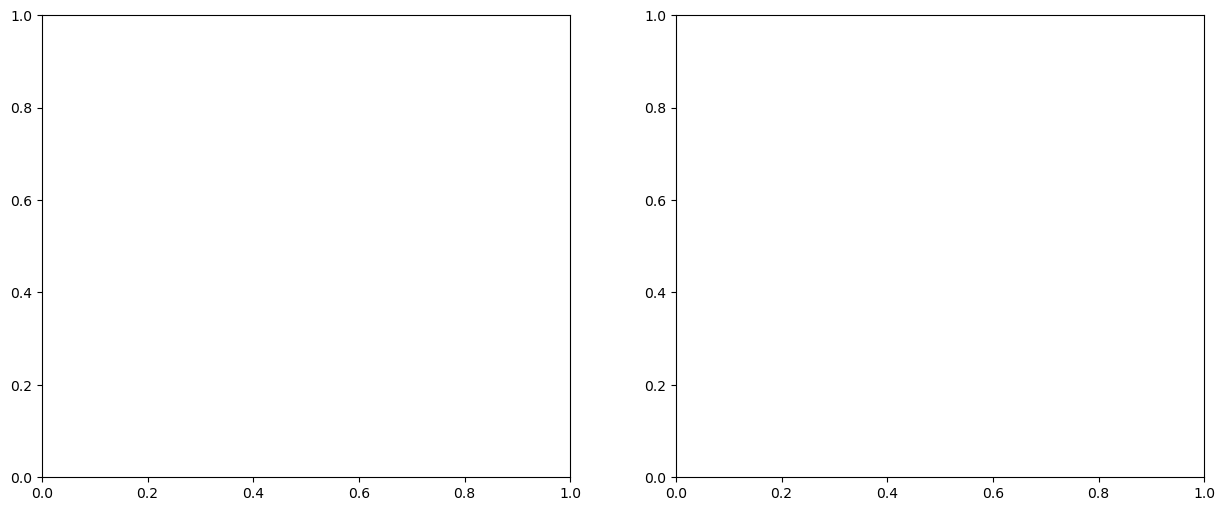

In [34]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import roc_curve, roc_auc_score,auc



### Set Pandas options to display all rows and columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)

### Supress warnings
import warnings; warnings.simplefilter('ignore')

###########################################################################
# What we want to predict #
pred_label = 'PINCP'
# exclude_labels= grade_labels
row_sel = 'Female'
eval_sel = ['Female', 'Male']
model = 'logistic'
cv = 30
seed = 777

############################################################################

# df_new = balance_data(df, ['urm', 'wa'], random_state=seed)
def printmd(string):
    display(Markdown(string))

# The ACS data source contains data for all fifty states, each of which has a
# slightly different distribution of features and response. This increases the
# diversity of environments in which we can evaluate our methods. For instance, we
# can generate another `ACSEmployment` task using data from Texas and repeat the
# experiment
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_ca = data_source.get_data(states=["CA"], download=True)

ca_features, ca_label, ca_group = ACSIncomeNew.df_to_numpy(acs_ca)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

yhat = model.predict(X_test)

sample_p = np.linspace(0,1,11)

# exclude_labels = exclude_labels | {pred_label} # Make sure not to include pred_label
x_labels = [x for x in list(acs_ca.columns.values)] #  if x not in exclude_labels

X = acs_ca[x_labels]
y = acs_ca[pred_label]

f, axs = plt.subplots(1,2, figsize=(15,6))

colormap = plt.cm.Reds 
colors1 = [colormap(i) for i in np.linspace(0.1, 1,len(sample_p))]
colormap = plt.cm.Blues
colors2 = [colormap(i) for i in np.linspace(0.1, 1,len(sample_p))]
auc_f, auc_m = [], []

tpr_m_list, fpr_m_list = [], []
tpr_f_list, fpr_f_list = [], []

for idx, p in enumerate(sample_p):
    print(p)
    ss = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=seed)

    
    tprs_f, tprs_m = [], []
    aucs_f, aucs_m = [], []
    mean_fpr = np.linspace(0, 1, 100)

    fnr_f, fpr_f = [], []
    fnr_m, fpr_m = [], []
    for train, test in tqdm(ss.split(X)):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

        np.random.seed(0)
        X_train = select_rows_p(X_train, 'Female', p)
        y_train = y_train.loc[X_train.index]

        pred_model = train_model(X_train, y_train, model)
        metrics =  eval_binary_metrics(pred_model, X_test, y_test, eval_sel)
        fnr_f.append(metrics['f']['FNR'])
        fpr_f.append(metrics['f']['FPR'])
        fnr_m.append(metrics['m']['FNR'])
        fpr_m.append(metrics['m']['FPR'])
        
        X_eval_g = select_rows(X_test, 'Female')
        y_eval_g= y_test.loc[X_eval_g.index]
        y_score = pred_model.predict_proba(X_eval_g)[:,1]
        fpr, tpr, _ = roc_curve(y_eval_g, y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs_f.append(interp_tpr)
        
        X_eval_g = select_rows(X_test, 'Male')
        y_eval_g= y_test.loc[X_eval_g.index]
        y_score = pred_model.predict_proba(X_eval_g)[:,1]
        fpr, tpr, _ = roc_curve(y_eval_g, y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs_m.append(interp_tpr)
    
    mean_tpr = np.mean(tprs_f, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs_f)
    auc_f.append(mean_auc)
    axs[0].plot(mean_fpr, mean_tpr, lw=2, alpha=.8, color= colors1[idx], label='p={:.1f}'.format(p), zorder=0)
    tpr_f_list.append(1-np.mean(fnr_f))
    fpr_f_list.append(np.mean(fpr_f))
#     axs[0].scatter(np.mean(fpr_f), 1-np.mean(fnr_f), color = colors1[idx], s=50)
    
    std_tpr = np.std(tprs_f, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    mean_tpr = np.mean(tprs_m, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs_m)
    auc_m.append(mean_auc)
    axs[1].plot(mean_fpr, mean_tpr, lw=2, alpha=.8, color = colors2[idx], label='p={:.1f}'.format(p), zorder=0)
    tpr_m_list.append(1-np.mean(fnr_m))
    fpr_m_list.append(np.mean(fpr_m))
#     axs[1].scatter(np.mean(fpr_m), 1-np.mean(fnr_m), color = colors2[idx], s=50)
    std_tpr = np.std(tprs_m, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

for i in range(len(sample_p)):
    axs[0].scatter(fpr_f_list[i], tpr_f_list[i], color = colors1[i], s=100, zorder=(i+1))
    axs[1].scatter(fpr_m_list[i], tpr_m_list[i], color = colors2[i], s=100, zorder=(i+1))
    
axs[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
axs[1].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)    
axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)    

axs[0].set_title('URM ROC Curves')
axs[1].set_title('WA ROC Curves')
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')

# plt.savefig('hsls_roc_race.pdf')
# axs[2].scatter(sample_p,auc_f, color='red', label='URM')
# axs[2].scatter(sample_p,auc_m, color='blue', label='WA')
# axs[2].set_xlabel('p')
# axs[2].set_ylabel('AUC')
# axs[2].legend(loc="lower right")

